## FIFA Players - Clustering and Dimension Reduction Project

**Goal**: To identify replacements for a player in the same national team using clusterig techniques. We assume Fifa ratings as the most accurate representation of football players ability, and using that, try to identfy who will be the closest replacement for each player in national teams. In this project we will use 5 national teams and try to find the next best player from the playing 11. 

I will cover both dimension reduction and clustering in this project. 

In [1]:
# Import all necessary libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn import preprocessing
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.graph_objects as go
from scipy.spatial import ConvexHull
from IPython.display import Image
from factor_analyzer.factor_analyzer import calculate_kmo
import kagglehub
from sklearn.manifold import TSNE


# Data Source

Kaggle - https://www.kaggle.com/datasets/stefanoleone992/ea-sports-fc-24-complete-player-dataset/data

In [2]:
# Download and extract the dataset
path = kagglehub.dataset_download("stefanoleone992/ea-sports-fc-24-complete-player-dataset")

# Load the FIFA dataset into a DataFrame
fifa_data = pd.read_csv(path + '/male_players.csv', low_memory=False)


# Basic about player positions

This will be useful when we do clustering. 

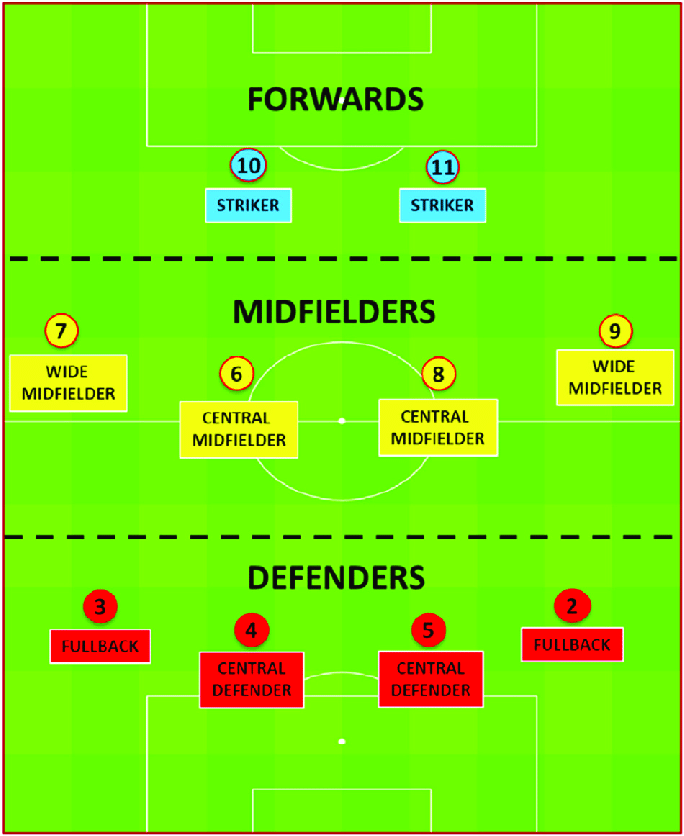

In [3]:
Image("images/player_layout.png")

The data contains 100+ columns, of which around 60 are important features to us. Most of the columns are player attributes which are rated from 1-99.
Info about each column can be found from Kaggle link above. 

In [4]:
fifa_data.head()

,player_id,player_url,fifa_version,fifa_update,update_as_of,short_name,long_name,player_positions,overall,potential,...,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
0,231747,/player/231747/kylian-mbappe/240002,24.0,2.0,2023-09-22,K. Mbappé,Kylian Mbappé Lottin,"ST, LW",91,94,...,63+3,63+3,63+3,68+3,63+3,54+3,54+3,54+3,63+3,18+3
1,239085,/player/239085/erling-haaland/240002,24.0,2.0,2023-09-22,E. Haaland,Erling Braut Haaland,ST,91,94,...,63+3,63+3,63+3,62+3,60+3,62+3,62+3,62+3,60+3,19+3
2,192985,/player/192985/kevin-de-bruyne/240002,24.0,2.0,2023-09-22,K. De Bruyne,Kevin De Bruyne,"CM, CAM",91,91,...,80+3,80+3,80+3,79+3,75+3,70+3,70+3,70+3,75+3,21+3
3,158023,/player/158023/lionel-messi/240002,24.0,2.0,2023-09-22,L. Messi,Lionel Andrés Messi Cuccittini,"CF, CAM",90,90,...,63+3,63+3,63+3,64+3,59+3,49+3,49+3,49+3,59+3,19+3
4,165153,/player/165153/karim-benzema/240002,24.0,2.0,2023-09-22,K. Benzema,Karim Benzema,"CF, ST",90,90,...,64+3,64+3,64+3,64+3,60+3,55+3,55+3,55+3,60+3,18+3


# Comments on Data Filtering 

Here, we make a decision to keep players from fifa 24 only. The data has info about players from last 4-5 different fifa versions, but that is not relevant to us. 

In [5]:
# Filter the data for fifa_version == 2024
fifa_24 = fifa_data[fifa_data['fifa_version'] == 24]

# # I am only interested in players above 70 rating as players below that usually do not make it to first team. 
# This approach helps to keep clusters clean and not too populated. I tested without adding rating filter and results 
# were similar, however more cluttered. 
fifa_24 = fifa_24[fifa_24['overall'] > 70]

fifa_24.describe().columns # numeric variables only

Index(['player_id', 'fifa_version', 'fifa_update', 'overall', 'potential',
       'value_eur', 'wage_eur', 'age', 'height_cm', 'weight_kg',
       'club_team_id', 'league_id', 'league_level', 'club_jersey_number',
       'club_contract_valid_until_year', 'nationality_id', 'nation_team_id',
       'nation_jersey_number', 'weak_foot', 'skill_moves',
       'international_reputation', 'release_clause_eur', 'pace', 'shooting',
       'passing', 'dribbling', 'defending', 'physic', 'attacking_crossing',
       'attacking_finishing', 'attacking_heading_accuracy',
       'attacking_short_passing', 'attacking_volleys', 'skill_dribbling',
       'skill_curve', 'skill_fk_accuracy', 'skill_long_passing',
       'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed',
       'movement_agility', 'movement_reactions', 'movement_balance',
       'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength',
       'power_long_shots', 'mentality_aggression', 'mentality_intercept

## Doing some basic Exploratory Data Analysis to understand the data and distribution

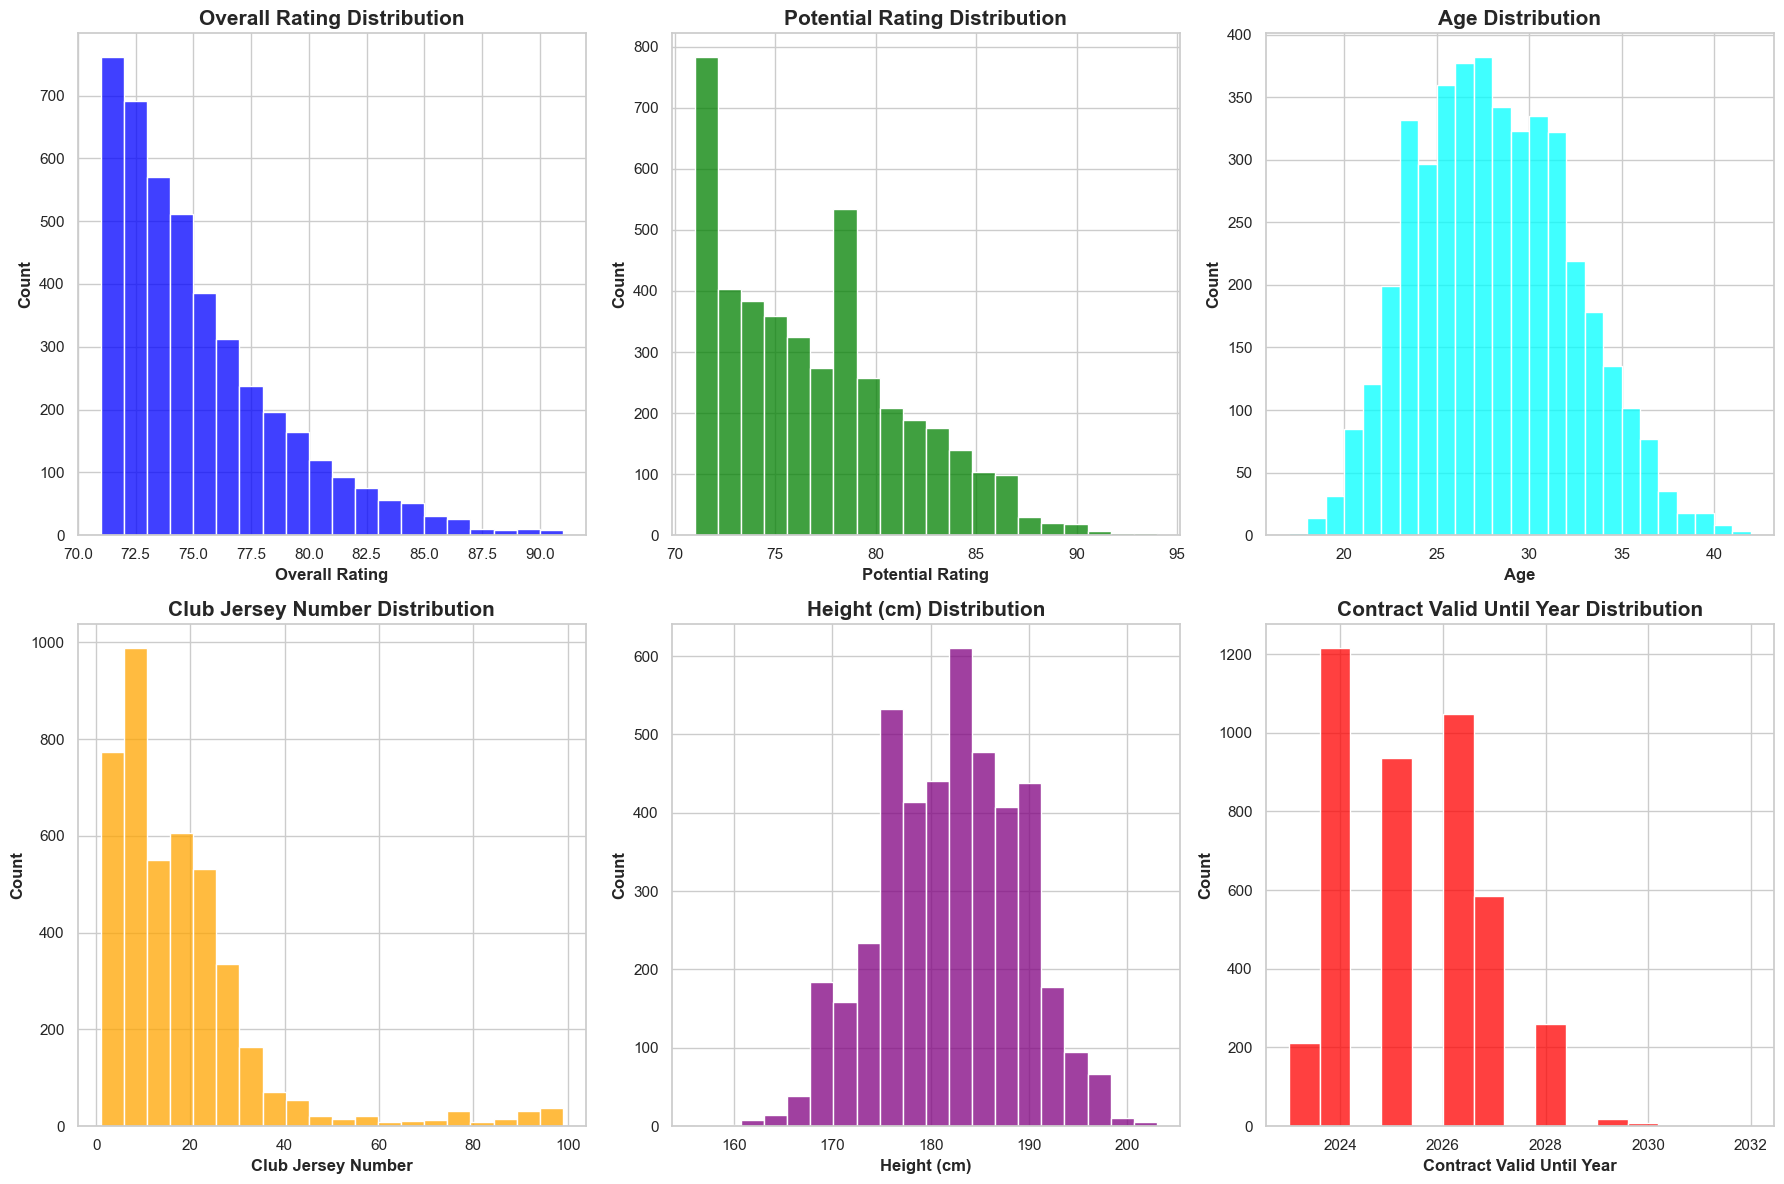

In [6]:

# Set a consistent style
sns.set_theme(style="whitegrid")

# Set the figure size
plt.figure(figsize=(18, 12))


plt.subplot(2, 3, 1)
sns.histplot(fifa_24['overall'], bins=20, kde=False, color="blue")
plt.xlabel('Overall Rating', fontsize=12, fontweight="bold")
plt.ylabel('Count', fontsize=12, fontweight="bold")
plt.title('Overall Rating Distribution', fontsize=15, fontweight="bold")


plt.subplot(2, 3, 2)
sns.histplot(fifa_24['potential'], bins=20, kde=False, color="green")
plt.xlabel('Potential Rating', fontsize=12, fontweight="bold")
plt.ylabel('Count', fontsize=12, fontweight="bold")
plt.title('Potential Rating Distribution', fontsize=15, fontweight="bold")


plt.subplot(2, 3, 3)
sns.histplot(fifa_24['age'], bins=25, kde=False, color="cyan")
plt.xlabel('Age', fontsize=12, fontweight="bold")
plt.ylabel('Count', fontsize=12, fontweight="bold")
plt.title('Age Distribution', fontsize=15, fontweight="bold")


plt.subplot(2, 3, 4)
sns.histplot(fifa_24['club_jersey_number'], bins=20, kde=False, color="orange")
plt.xlabel('Club Jersey Number', fontsize=12, fontweight="bold")
plt.ylabel('Count', fontsize=12, fontweight="bold")
plt.title('Club Jersey Number Distribution', fontsize=15, fontweight="bold")


plt.subplot(2, 3, 5)
sns.histplot(fifa_24['height_cm'], bins=20, kde=False, color="purple")
plt.xlabel('Height (cm)', fontsize=12, fontweight="bold")
plt.ylabel('Count', fontsize=12, fontweight="bold")
plt.title('Height (cm) Distribution', fontsize=15, fontweight="bold")


plt.subplot(2, 3, 6)
sns.histplot(fifa_24['club_contract_valid_until_year'], bins=15, kde=False, color="red")
plt.xlabel('Contract Valid Until Year', fontsize=12, fontweight="bold")
plt.ylabel('Count', fontsize=12, fontweight="bold")
plt.title('Contract Valid Until Year Distribution', fontsize=15, fontweight="bold")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


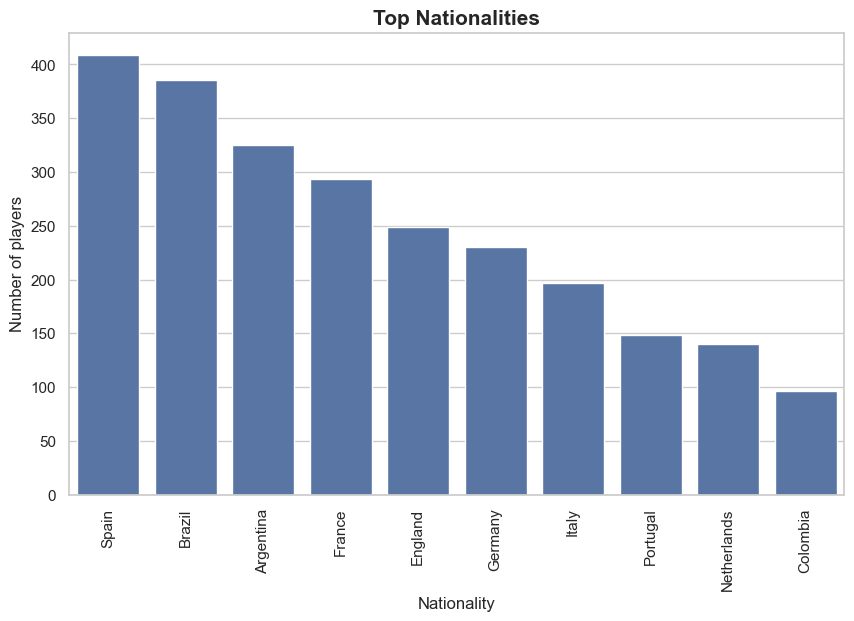

In [7]:
# barplot to understand the distribution of players country wise

top_nationalities=fifa_24.nationality_name.value_counts(ascending=False)[:10]

plt.figure(figsize=(10,6))
sns.barplot(top_nationalities)
plt.xlabel('Nationality')
plt.ylabel('Number of players')
plt.xticks(rotation=90)
plt.title('Top nationalities'.title(), fontsize=15, fontweight="bold");

# Chosen Nationalities 
### Based on my interest, this is just a sample list which can be modified
For identifying potential replacements for each position. 

1. Poland
2. England
3. Germany
4. Spain
5. France

In [8]:
fifa_24 = fifa_24[fifa_24['nationality_name'].isin(['Poland', 'Italy', 'Germany', 'Spain', 'France'])]

In [9]:
# fifa_24.describe

### Updating dataset to keep only numerical cols for Dimension reduction and clustering. We have also kept player name and nationality to use it for player cluster mappign in future

In [10]:
fifa_24 = fifa_24[['short_name', 'nationality_name','overall', 'potential',
       'value_eur', 'wage_eur', 'age', 'height_cm', 'weight_kg',
       'league_level', 'club_jersey_number',
       'club_contract_valid_until_year',
       'weak_foot', 'skill_moves',
       'international_reputation', 'release_clause_eur', 'pace', 'shooting',
       'passing', 'dribbling', 'defending', 'physic', 'attacking_crossing',
       'attacking_finishing', 'attacking_heading_accuracy',
       'attacking_short_passing', 'attacking_volleys', 'skill_dribbling',
       'skill_curve', 'skill_fk_accuracy', 'skill_long_passing',
       'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed',
       'movement_agility', 'movement_reactions', 'movement_balance',
       'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength',
       'power_long_shots', 'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'defending_marking_awareness',
       'defending_standing_tackle', 'defending_sliding_tackle',
       'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes', 'goalkeeping_speed']]

### Identifying how many nulls we have in the dataset

In [11]:
pd.set_option('display.max_rows', 500)
fifa_24.isnull().sum()

short_name                           0
nationality_name                     0
overall                              0
potential                            0
value_eur                            0
wage_eur                             0
age                                  0
height_cm                            0
weight_kg                            0
league_level                         0
club_jersey_number                   0
club_contract_valid_until_year       0
weak_foot                            0
skill_moves                          0
international_reputation             0
release_clause_eur                  79
pace                               127
shooting                           127
passing                            127
dribbling                          127
defending                          127
physic                             127
attacking_crossing                   0
attacking_finishing                  0
attacking_heading_accuracy           0
attacking_short_passing  

# Comments on Data Cleaning

We can see above that we have some cols as nulls in the data
I looked through each column (eg. pace, dribbling, goalkeeping_speed, defending etc) - Some players have these metrics missing in the data/

Based on my data understanding putting in mean for missing values seems reasonable. We could potentially think of better ways to fill the data synthetically, but mean provides a good balance between speed of implementation and quality. (I tested by putting values synthetically, end result was similar)

In [12]:
names = fifa_24.short_name.tolist() # saving names for later
countries = fifa_24.nationality_name.tolist()

fifa_24 = fifa_24.drop(['short_name', 'nationality_name'], axis = 1) # drop the short_name column 


In [13]:
fifa_24 = fifa_24.fillna(fifa_24.mean())

## Scaling the data for PCA

In [14]:
x = fifa_24.values # numpy array
scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(x)
X_norm = pd.DataFrame(x_scaled)
     

In [15]:
# Calculate the Kaiser-Meyer-Olkin (KMO) measure for the dataset
kmo_all, kmo_model = calculate_kmo(x_scaled)

kmo_model


/usr/local/lib/python3.9/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


0.8929585501231798

### We can see the Kaiser-Meyer-Olkin (KMO) measure is almost 0.9, which is a strong indication for doing dimension reduction.

# Dimension Reduction (PCA)

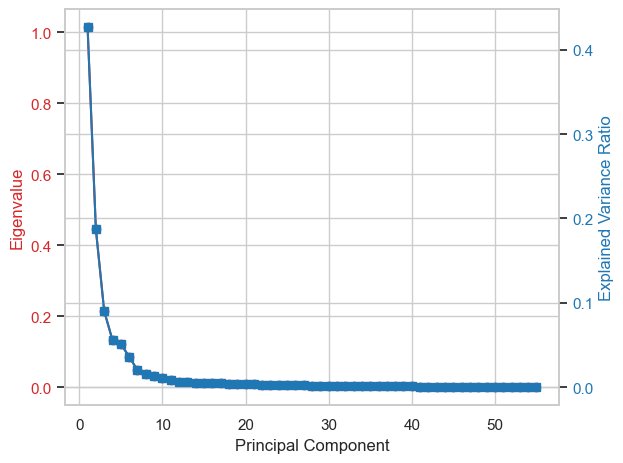

In [16]:
pca_adjusted = PCA()
pca_adjusted.fit(x_scaled)

# Eigenvalues and Explained Variance Ratio
eigenvalues_adjusted = pca_adjusted.explained_variance_
explained_variance_ratio_adjusted = pca_adjusted.explained_variance_ratio_
cumulative_explained_variance_ratio_adjusted = np.cumsum(explained_variance_ratio_adjusted)

# Plotting the eigenvalues and explained variance ratio
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Eigenvalue', color=color)
ax1.plot(np.arange(1, len(eigenvalues_adjusted) + 1), eigenvalues_adjusted, 'o-', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Explained Variance Ratio', color=color)
ax2.plot(np.arange(1, len(explained_variance_ratio_adjusted) + 1), explained_variance_ratio_adjusted, 's-', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

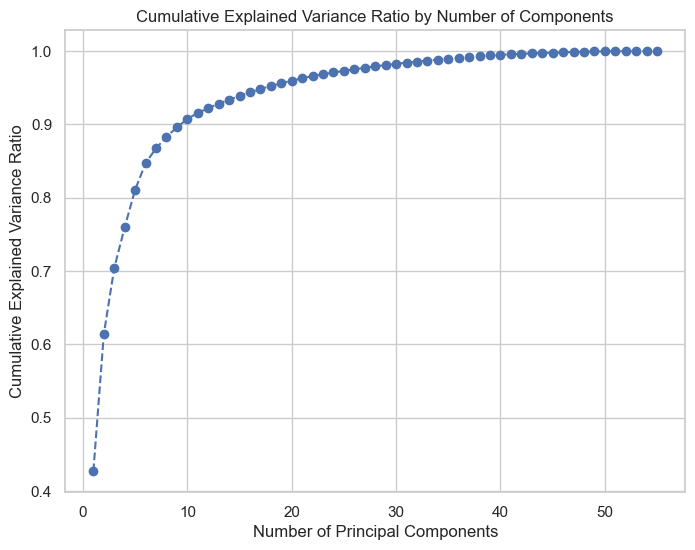

In [17]:
# Plotting the cumulative explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(cumulative_explained_variance_ratio_adjusted) + 1), cumulative_explained_variance_ratio_adjusted, 'o--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio by Number of Components')
plt.grid(True)
plt.show()

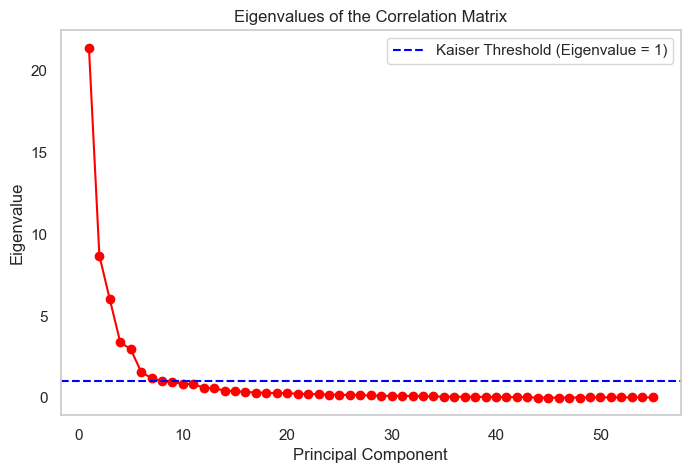

Number of components retained using the Kaiser Rule: 8


In [18]:
# Compute the correlation matrix
correlation_matrix = np.corrcoef(x_scaled, rowvar=False)

# Compute eigenvalues of the correlation matrix
eigenvalues, eigenvectors = np.linalg.eig(correlation_matrix)



plt.figure(figsize=(8, 5))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, 'o-', color='red')
plt.axhline(y=1, color='blue', linestyle='--', label='Kaiser Threshold (Eigenvalue = 1)')
plt.title('Eigenvalues of the Correlation Matrix')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.legend()
plt.grid()
plt.show()

# Apply the Kaiser Stopping Rule (retain components with eigenvalue > 1)
kaiser_components = np.sum(eigenvalues > 1)
print(f"Number of components retained using the Kaiser Rule: {kaiser_components}")


In [19]:
# Assuming you have already fit a PCA object called `pca_adjusted`
explained_variance_ratio = pca_adjusted.explained_variance_ratio_

# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Print the cumulative explained variance
for i, var in enumerate(cumulative_explained_variance, start=1):
    print(f"Principal Component {i}: {var:.4f}")

Principal Component 1: 0.4269
Principal Component 2: 0.6139
Principal Component 3: 0.7041
Principal Component 4: 0.7598
Principal Component 5: 0.8110
Principal Component 6: 0.8472
Principal Component 7: 0.8674
Principal Component 8: 0.8830
Principal Component 9: 0.8961
Principal Component 10: 0.9074
Principal Component 11: 0.9158
Principal Component 12: 0.9222
Principal Component 13: 0.9284
Principal Component 14: 0.9337
Principal Component 15: 0.9389
Principal Component 16: 0.9438
Principal Component 17: 0.9485
Principal Component 18: 0.9524
Principal Component 19: 0.9563
Principal Component 20: 0.9597
Principal Component 21: 0.9631
Principal Component 22: 0.9660
Principal Component 23: 0.9686
Principal Component 24: 0.9709
Principal Component 25: 0.9731
Principal Component 26: 0.9753
Principal Component 27: 0.9773
Principal Component 28: 0.9792
Principal Component 29: 0.9810
Principal Component 30: 0.9827
Principal Component 31: 0.9842
Principal Component 32: 0.9857
Principal Compone

# Comments on Dimension Reduction

While Kaiser Method suggest 8 PCA Components, based on my understanding of data and keeping in mind that we need to create clusters for this data. I will be using 2 & 3 PCAs, which still represent around 61% and 71% of data respectively. 

We had ~60 columns (or features) initially, reducing that to 2-3 while keeping around 71% explained variance is a good trade off. 

**Note** - Ideally we would want to reduce the values to 4-5 dimensions to have 81% Explained Variance. 


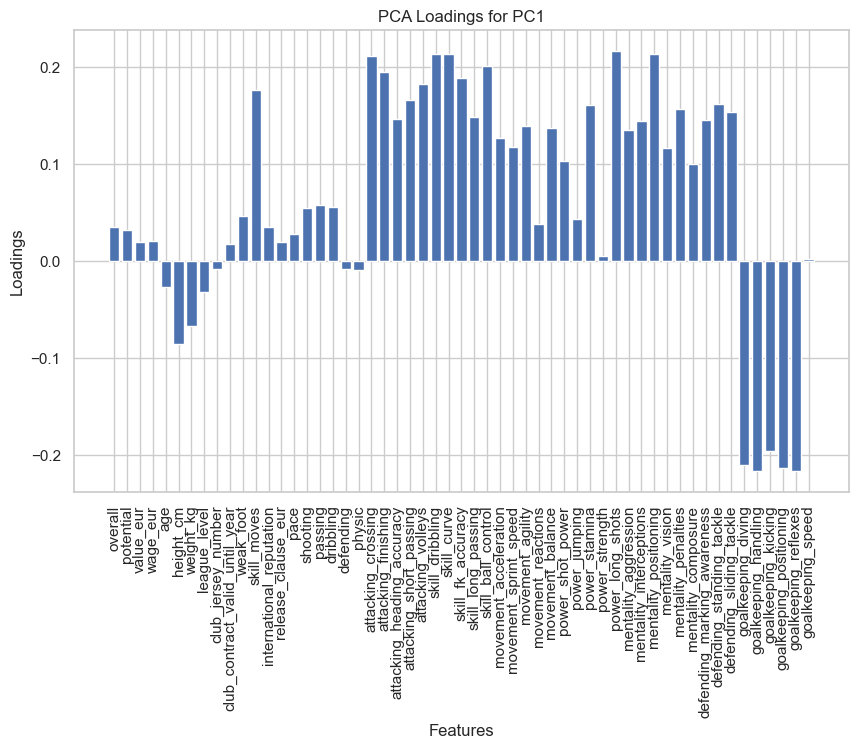

In [20]:
# Apply PCA
pca = PCA(n_components=8)
pca_transformed = pca.fit_transform(x_scaled)
# Get the loadings (components)
loadings = pca.components_

# Visualizing Loadings for the first component (PC1)
plt.figure(figsize=(10, 6))
plt.bar(fifa_24.columns, loadings[0])
plt.title('PCA Loadings for PC1')
plt.xlabel('Features')
plt.ylabel('Loadings')
plt.xticks(rotation=90)
plt.show()

# Calculate Contributions for each feature in PC1 (square of loadings, normalized)
contributions = np.square(loadings[0]) / np.sum(np.square(loadings[0]))
contributions_df = pd.DataFrame(contributions, index=fifa_24.columns, columns=['Contribution to PC1'])


## Before moving to Clustering, I will also perform t-SNE to 3 dimensions to get some intuituion of data

In [21]:
# Apply t-SNE
tsne = TSNE(n_components=3, random_state=42)
tsne_transformed = tsne.fit_transform(x_scaled)

# Create a DataFrame for the transformed data
tsne_df = pd.DataFrame(
    tsne_transformed,
    columns=[f"tSNE{i+1}" for i in range(tsne_transformed.shape[1])],  # Use the correct number of columns
    index=X_norm.index  # Use the index from the scaled data
)

# Output
print("\nt-SNE Transformed Data (first 20 rows):")
print(tsne_df.head(20))



t-SNE Transformed Data (first 20 rows):
        tSNE1     tSNE2      tSNE3
0    7.228813 -9.498034  -5.078333
1    7.657258 -9.430084  -4.393426
2    7.717175 -9.460689  -4.568188
3    6.321317  1.383491  -9.676646
4  -15.468895  1.902557  -0.158855
5    5.846949  0.159852  -9.540706
6    7.505879 -8.729895  -5.312938
7  -13.401457  1.091207   0.129319
8  -15.448823  1.782487  -0.076037
9  -15.505864  1.870734  -0.345543
10   6.075162 -7.480608  -6.487817
11   4.662322 -0.199718 -10.397152
12   5.523510  0.898376  -9.396235
13   5.509513  0.078927  -9.633279
14   6.671454 -7.816911  -6.016456
15   5.301864 -8.848525  -5.162447
16   7.253363 -1.501220  -6.353473
17 -14.878437  0.945633   0.038672
18   7.097905 -1.650099  -6.389159
19   6.998824 -0.969311  -6.021775


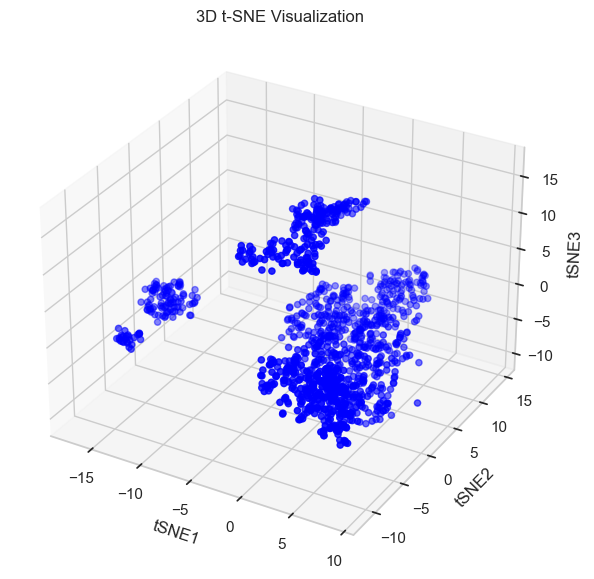

In [22]:

# Plotting 3D scatter plot using matplotlib
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for t-SNE transformed data
ax.scatter(tsne_df['tSNE1'], tsne_df['tSNE2'], tsne_df['tSNE3'], c='blue', marker='o')

# Labels and title
ax.set_xlabel('tSNE1')
ax.set_ylabel('tSNE2')
ax.set_zlabel('tSNE3')
ax.set_title('3D t-SNE Visualization')

plt.show()


# 2D Clustering and Analysis

Let's start by using first 2 PCAs and builidng the clusters. We will use PCA1 and PCA2.

We have already established that 4 PCAs would be ideal, but for clustering to be clear and understanding, 2 or 3 dimensional visuals would be best, so we will use those two options. 

In [23]:
pca = PCA(n_components = 2)  #For Clustering
reduced = pd.DataFrame(pca.fit_transform(X_norm))
     

For a quick check, Running the Elbow method to identify number of clusters

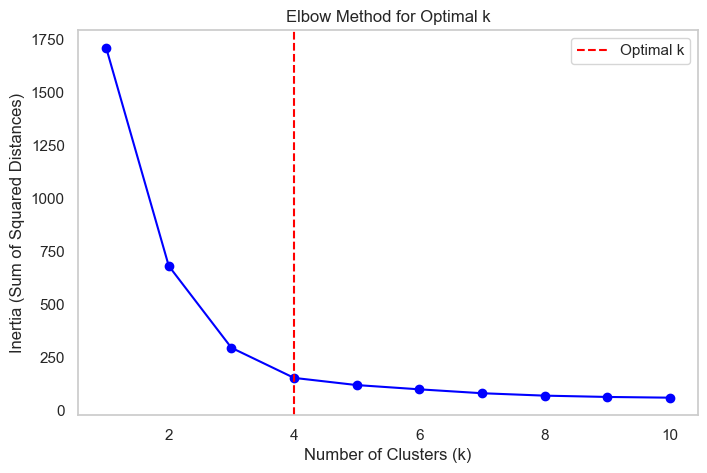

In [24]:
# Calculate inertia for a range of cluster numbers
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(reduced)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'o-', color='blue')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method for Optimal k')
plt.axvline(x=4, color='red', linestyle='--', label='Optimal k')
plt.legend()
plt.grid()
plt.show()


Validating the information by silhoutte method

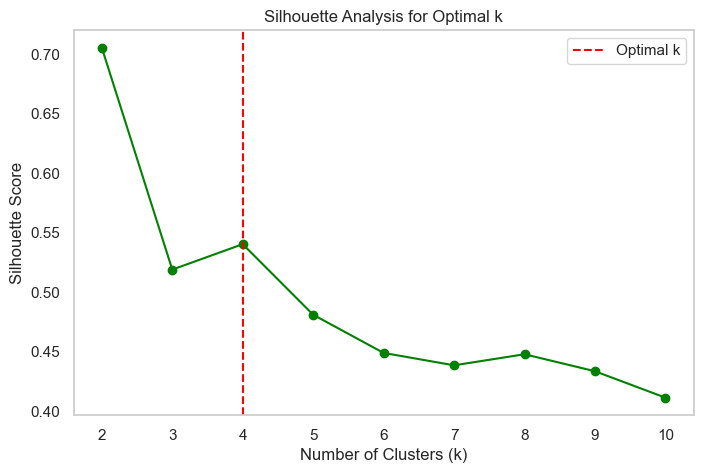

In [25]:
silhouette_scores = []

# Compute silhouette scores for a range of cluster numbers
for k in range(2, 11):  # Silhouette cannot be computed for k=1
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(reduced)
    score = silhouette_score(reduced, labels)
    silhouette_scores.append(score)

# Plot the silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, 'o-', color='green')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal k')
plt.axvline(x=4, color='red', linestyle='--', label='Optimal k')
plt.legend()
plt.grid()
plt.show()


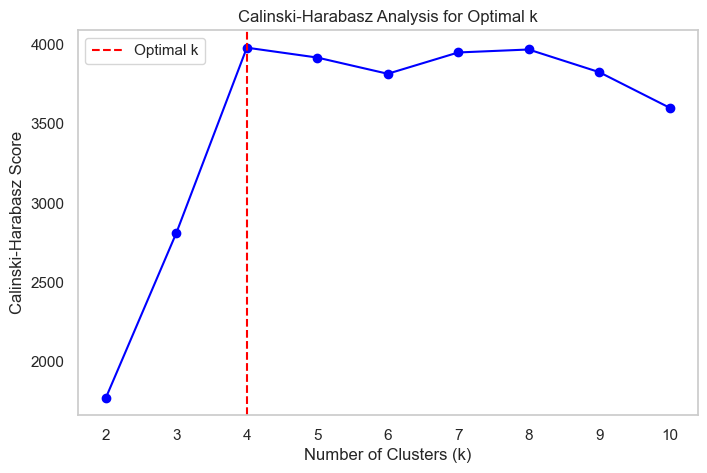

In [26]:


calinski_scores = []

# Compute Calinski-Harabasz scores for a range of cluster numbers
for k in range(2, 11):  
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(reduced)
    score = calinski_harabasz_score(reduced, labels)
    calinski_scores.append(score)

# Plot the Calinski-Harabasz scores
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), calinski_scores, 'o-', color='blue')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Calinski-Harabasz Score')
plt.title('Calinski-Harabasz Analysis for Optimal k')
plt.axvline(x=4, color='red', linestyle='--', label='Optimal k')
plt.legend()
plt.grid()
plt.show()


# Comment on Number of CLusters

Based on Elbow method & Silhoutte and confirmed by Calinski-Harabasz score analysis, 4 seems like the ideal number of clusters. We will start clustering based on that (based on my domain knowledge it should be 5 clsuters and I will explain later why)

In [27]:
# specify the number of clusters
kmeans = KMeans(n_clusters=4)

# fit the input data
kmeans = kmeans.fit(reduced)

# get the cluster labels
labels = kmeans.predict(reduced)

# centroid values
centroid = kmeans.cluster_centers_

# cluster values
clusters = kmeans.labels_.tolist()
     

In [28]:
reduced['cluster'] = clusters
reduced['name'] = names
reduced['countries'] = countries
reduced.columns = ['PC1', 'PC2', 'cluster', 'name', 'countries']
reduced.head(10)

,PC1,PC2,cluster,name,countries
0,1.330597,-1.252397,1,K. Mbappé,France
1,1.100819,-1.055921,1,K. Benzema,France
2,1.184873,-0.910287,1,R. Lewandowski,Poland
3,1.007988,0.534693,3,Rodri,Spain
4,-2.425934,-0.421658,2,M. ter Stegen,Germany
5,1.327762,0.151557,3,J. Kimmich,Germany
6,1.404287,-0.660321,1,A. Griezmann,France
7,-2.555523,-0.451577,2,G. Donnarumma,Italy
8,-2.244408,-0.402102,2,M. Maignan,France
9,-2.344656,-0.423623,2,M. Neuer,Germany


In [29]:
# correlation_matrix = pd.DataFrame(x_scaled).corr()
# print(correlation_matrix)


### List of players to label. These are players from my team in career mode. They represent all positions. I have also added some extra players to make data more representative

### My goal is to identify where they fall and find similar players as replacement. 



In [30]:

# players_to_label = [
#     "K. Mbappé", "L. Messi", "R. Lewandowski", "E. Haaland", "Cristiano Ronaldo",  # Attack
#     "O. Watkins", "D. Ings", "P. Bamford" , # Attack
#     "K. De Bruyne", "P. Pogba", "L. Modrić", "F. De Jong", "T. Kroos", # Mid
#     "P. Zieliński", "J. McGinn", "L. Bailey", "I. Gündoğan", "R. Højbjerg", # Mid
#     "V. van Dijk", "J. Tomkins", "J. Stones", "K. Koulibaly", "J. Laporte", # Defenders
#     "C. Coady", "J. Moreno", "O. Skipp", "J. Koundé", "F. Mendy", # Full Backs
#     "W. Szczęsny", "R. Patricio", "D. Raya", "M. Ginter" #Goal Keepers
# ]

In [31]:


# Function to create cluster outlines using Convex Hull
def add_cluster_outlines(fig, data, cluster_col, x_col, y_col, color_scale):
    unique_clusters = data[cluster_col].unique()
    for cluster in unique_clusters:
        cluster_points = data[data[cluster_col] == cluster][[x_col, y_col]].values
        if len(cluster_points) > 2:  
            hull = ConvexHull(cluster_points)
            hull_points = cluster_points[hull.vertices]
            # Add cluster outline as a filled scatter plot
            fig.add_trace(
                go.Scatter(
                    x=hull_points[:, 0],
                    y=hull_points[:, 1],
                    mode='lines',
                    fill='toself',
                    line=dict(color=color_scale[cluster % len(color_scale)], width=2),
                    opacity=0.2,
                    name=f"Cluster {cluster} Outline",
                    showlegend=False,
                )
            )

reduced['cluster'] = reduced['cluster'].astype('category')
reduced['cluster'] = reduced['cluster'].cat.rename_categories({i: i+1 for i in range(len(reduced['cluster'].cat.categories))})

color_scale = px.colors.qualitative.Set1  

# Create scatter plot for all points (dots)
fig = px.scatter(
    reduced,
    x="PC1",
    y="PC2",
    color="cluster",  # Now treated as categorical
    color_discrete_sequence=color_scale,  
    opacity=0.6,
    labels={"PC1": "Principal Component 1", "PC2": "Principal Component 2"},
    category_orders={"cluster": sorted(reduced['cluster'].unique())},  
)

# Add cluster outlines
add_cluster_outlines(fig, reduced, "cluster", "PC1", "PC2", color_scale)

# Update layout for better appearance
fig.update_layout(
    title="2 Dimension Cluster Plot",
    title_font=dict(size=20, family="Arial Black"),
    xaxis=dict(title=f"PC 1, Explained Variance Ratio - {explained_variance_ratio[0]:.2%}", titlefont=dict(size=16), showgrid=False),
    yaxis=dict(title=f"PC 2, Explained Variance Ratio - {explained_variance_ratio[1]:.2%}", titlefont=dict(size=16), showgrid=False),
    template="plotly_white",
    legend=dict(
        title="Clusters",
        font=dict(size=12),
        orientation="v", 
        yanchor="top",
        y=1,
        xanchor="left",
        x=1.05,  
        bordercolor="Black",
        borderwidth=1,
        bgcolor="white",
    ),
    width=1000,
    height=700,
)

# Show plot
fig.show()


In [32]:
reduced

,PC1,PC2,cluster,name,countries
0,1.330597,-1.252397,2,K. Mbappé,France
1,1.100819,-1.055921,2,K. Benzema,France
2,1.184873,-0.910287,2,R. Lewandowski,Poland
3,1.007988,0.534693,4,Rodri,Spain
4,-2.425934,-0.421658,3,M. ter Stegen,Germany
...,...,...,...,...,...
1169,0.080543,-0.733855,2,Dani Raba,Spain
1170,0.175601,-0.637435,2,A. Bamba,France
1171,0.258162,-0.757691,2,K. Pröger,Germany
1172,-0.048576,0.484095,1,J. Mellot,France


## In the above figure we can see 4 different clusters, which seem to be well strcutured, with minimal overlap. To understand the clusters let's plot player names into it 

In [33]:
# Group players by clusters and limit to 5 players per cluster
clusters = reduced['cluster'].unique()
for cluster in clusters:
    # Filter players in the current cluster
    players_in_cluster = reduced[reduced['cluster'] == cluster]
    
    # Select up to 5 players
    selected_players = players_in_cluster.head(5)
    
    # Add scatter plot traces for the selected players
    for _, row in selected_players.iterrows():
        fig.add_trace(
            go.Scatter(
                x=[row['PC1']],
                y=[row['PC2']],
                mode='markers',
                marker=dict(size=8, color='red', symbol='circle', line=dict(width=1, color='black')),
                name=None,  # Remove player from legend
                showlegend=False,
            )
        )
        
        # Add annotations for the selected players
        fig.add_annotation(
            x=row['PC1'],
            y=row['PC2'] - 0.1,  # Adjust vertical positioning slightly for better readability
            text=row['name'],  # Display player name
            showarrow=False,  
            font=dict(size=12, color='black', family="Arial Black"),
            align="left",
            bordercolor="#c7c7c7",
            borderwidth=2,
            borderpad=4,
            bgcolor="white",
            opacity=0.8
        )

# Update layout for better appearance
fig.update_layout(
    title="4 Cluster Scatter Plot with Names of 5 Players per Cluster",
    title_font=dict(size=20, family="Arial Black"),
    xaxis=dict(title="PC 1", titlefont=dict(size=16), showgrid=False),
    yaxis=dict(title="PC 2", titlefont=dict(size=16), showgrid=False),
    template="plotly_white",
    legend=dict(
        title="Clusters",
        font=dict(size=12),
        orientation="v",  
        yanchor="top",
        y=1,
        xanchor="left",
        x=1.05,  
        bordercolor="Black",
        borderwidth=1,
        bgcolor="white",
    ),
    width=1000,
    height=700,
)

# Show plot
fig.show()


# Comment on Clustering Outcome
The 4 clusters, while well structured, seem to put strikers (Lewandowski, Mbappe etc) in same group as mid fielders (Toni Kroos, De bruyne etc). Similarly, full backs (Left and right defensive players) are falling somewhere between 1st and 3rd Cluster.

Now based on my knowledge, I expect 5 clusters at a high level - Goalkeepers, Centre Backs, Full Backs, Midfielders and attackers. 

## So let's try same steps but with 5 Clusters

In [34]:

reduced = reduced.drop(["name", "countries", "cluster"], axis=1)

# specify the number of clusters
kmeans = KMeans(n_clusters=5)

# fit the input data
kmeans = kmeans.fit(reduced)

# get the cluster labels
labels = kmeans.predict(reduced)

# centroid values
centroid = kmeans.cluster_centers_

# cluster values
clusters = kmeans.labels_.tolist()
     

In [35]:
reduced['cluster'] = clusters
reduced['name'] = names
reduced['countries'] = countries
reduced.columns = ['PC1', 'PC2', 'cluster', 'name', 'countries']
reduced.head(10)

,PC1,PC2,cluster,name,countries
0,1.330597,-1.252397,3,K. Mbappé,France
1,1.100819,-1.055921,3,K. Benzema,France
2,1.184873,-0.910287,3,R. Lewandowski,Poland
3,1.007988,0.534693,0,Rodri,Spain
4,-2.425934,-0.421658,1,M. ter Stegen,Germany
5,1.327762,0.151557,0,J. Kimmich,Germany
6,1.404287,-0.660321,0,A. Griezmann,France
7,-2.555523,-0.451577,1,G. Donnarumma,Italy
8,-2.244408,-0.402102,1,M. Maignan,France
9,-2.344656,-0.423623,1,M. Neuer,Germany


## I will adding label positions myslef to make the clusters more understandable, they are not coming from actual data.

In [36]:
# Predefined label positions
label_positions = {
    'Goalkeeper': {'PC1': -2.5, 'PC2': -0.25},
    'Striker': {'PC1': 1.3, 'PC2': -1},
    'Midfield': {'PC1': 1.2, 'PC2': 0},
    'Full Back': {'PC1': 0.5, 'PC2': 0.25},
    'Defender': {'PC1': -0.2, 'PC2': 1},
}

# Ensure cluster labels are unique and start from 1
reduced['cluster'] = reduced['cluster'].astype('category')
unique_categories = reduced['cluster'].cat.categories.unique()  # Ensure categories are unique
category_mapping = {cat: idx + 1 for idx, cat in enumerate(unique_categories)}
reduced['cluster'] = reduced['cluster'].cat.rename_categories(category_mapping)

# Color palette for clusters
color_scale = px.colors.qualitative.Set1

# Create scatter plot for all points
fig = px.scatter(
    reduced,
    x="PC1",
    y="PC2",
    color="cluster",  
    color_discrete_sequence=color_scale,  
    labels={"PC1": "Principal Component 1", "PC2": "Principal Component 2"},
    category_orders={"cluster": sorted(reduced['cluster'].unique())},  
)

# Add cluster outlines (custom function assumed to exist)
add_cluster_outlines(fig, reduced, "cluster", "PC1", "PC2", color_scale)

# Select and annotate up to 5 players per cluster
clusters = reduced['cluster'].unique()  # Get all cluster labels
for cluster in clusters:
    # Filter players in the current cluster
    players_in_cluster = reduced[reduced['cluster'] == cluster]
    
    # Select up to 5 players from the cluster
    selected_players = players_in_cluster.head(5)
    
    # Add red markers for the selected players
    for _, row in selected_players.iterrows():
        fig.add_trace(
            go.Scatter(
                x=[row['PC1']],
                y=[row['PC2']],
                mode='markers',
                marker=dict(size=8, color='red', symbol='circle', line=dict(width=1, color='black')),
                name=None,  
                showlegend=False,
            )
        )
        
        # Add player annotations
        fig.add_annotation(
            x=row['PC1'],
            y=row['PC2'] - 0.1,  # Slight vertical adjustment for better readability
            text=row['name'],  # Only the player's name
            showarrow=False,  
            font=dict(size=12, color='black', family="Arial Black"),
            align="left",
            bordercolor="#c7c7c7",
            borderwidth=2,
            borderpad=4,
            bgcolor="white",
            opacity=0.8
        )

# Add predefined labels with an arrow pointing to the coordinates
for label, position in label_positions.items():
    fig.add_annotation(
        x=position['PC1'],  
        y=position['PC2'], 
        text=label,
        showarrow=True,  
        arrowhead=3,
        arrowsize=2,
        ax=150,  
        ay=-20, 
        font=dict(size=14, color='black'), 
        align="center", 
        bgcolor="white",
        opacity=0.8
    )

# Update layout for better appearance
fig.update_layout(
    title="5 Cluster Scatter Plot with 5 Player Names per Cluster",
    title_font=dict(size=20, family="Arial Black"),
    xaxis=dict(title="PC 1", titlefont=dict(size=16), showgrid=False),
    yaxis=dict(title="PC 2", titlefont=dict(size=16), showgrid=False),
    template="plotly_white",
    showlegend=True,  
    legend=dict(
        title="Clusters",
        font=dict(size=12),
        orientation="v",  
        yanchor="top",
        y=1,
        xanchor="left",
        x=1.05,  
        bordercolor="Black",
        borderwidth=1,
        bgcolor="white",
    ),
    width=1000,
    height=700,
)

# Show plot
fig.show()


# Comment on 5 cluster approach and my analysis

In the above plot 5 clear cluster can be clearly visualised. We can see most of the players fall in the cluster we expect them to based on their position. (we did not have this info in data when clustering)

We also notice some interesting occurences, such as Ferlan Mendy. He is placed in the cluster of midfielders (but very close to full backs) This related to the way he plays actually, as he often plays left mid or even if he is playing at full back, he is moving a lot and has a mid field type game style. 


In [37]:
import plotly.express as px
import plotly.graph_objects as go

# Predefined label positions
label_positions = {
    'Goalkeeper': {'PC1': -2.5, 'PC2': -0.25},
    'Striker': {'PC1': 1.3, 'PC2': -1},
    'Midfield': {'PC1': 1.2, 'PC2': 0},
    'Full Back': {'PC1': 0.5, 'PC2': 0.25},
    'Defender': {'PC1': -0.2, 'PC2': 1},
}

# Ensure cluster labels are unique and start from 1
reduced['cluster'] = reduced['cluster'].astype('category')
unique_categories = reduced['cluster'].cat.categories.unique()  # Ensure categories are unique
category_mapping = {cat: idx + 1 for idx, cat in enumerate(unique_categories)}
reduced['cluster'] = reduced['cluster'].cat.rename_categories(category_mapping)

# Color palette for clusters
color_scale = px.colors.qualitative.Set1

# List of countries
countries_list = ['Poland', 'Italy', 'Germany', 'Spain', 'France']

# Flag emojis for each country
flag_emojis = {
    'Poland': '🇵🇱',
    'Italy': '🇮🇹',
    'Germany': '🇩🇪',
    'Spain': '🇪🇸',
    'France': '🇫🇷'
}

# Iterate over countries to create separate plots for each
for country in countries_list:
    # Filter data for the current country
    country_data = reduced[reduced['countries'] == country]
    
    # Create scatter plot for all points, but hide the actual scatter points (show only outlines)
    fig = px.scatter(
        reduced,  # Use all data, not just the country-specific data
        x="PC1",
        y="PC2",
        color="cluster",  
        color_discrete_sequence=color_scale,  
        labels={"PC1": "Principal Component 1", "PC2": "Principal Component 2"},
        category_orders={"cluster": sorted(reduced['cluster'].unique())},  
    )
    
    # Add cluster outlines (custom function assumed to exist)
    add_cluster_outlines(fig, reduced, "cluster", "PC1", "PC2", color_scale)

    # Remove all scatter plot points (no markers or dots)
    fig.update_traces(marker=dict(opacity=0))  # Hide points for all clusters
    
    # Add scatter points for players from the current country with flag emojis
    country_players = country_data  # All players from the current country
    for _, row in country_players.iterrows():
        fig.add_trace(
            go.Scatter(
                x=[row['PC1']],
                y=[row['PC2']],
                mode='text',  # Only show text (flag emoji)
                text=[flag_emojis[country]],  # Use the flag emoji for the country
                textposition="top center",
                textfont=dict(size=25),  # Adjust the emoji size as needed
                name=None,  
                showlegend=False
            )
        )

    # Add predefined labels with an arrow pointing to the coordinates
    for label, position in label_positions.items():
        fig.add_annotation(
            x=position['PC1'],  
            y=position['PC2'], 
            text=label,
            showarrow=True,  
            arrowhead=3,
            arrowsize=2,
            ax=150,  
            ay=-20, 
            font=dict(size=14, color='black'), 
            align="center", 
            bgcolor="white",
            opacity=0.8
        )
    
    # Update layout for better appearance
    fig.update_layout(
        title=f"5 Cluster Scatter Plot for {country}",
        title_font=dict(size=20, family="Arial Black"),
        xaxis=dict(title="PC 1", titlefont=dict(size=16), showgrid=False),
        yaxis=dict(title="PC 2", titlefont=dict(size=16), showgrid=False),
        template="plotly_white",
        showlegend=True,  
        legend=dict(
            title="Clusters",
            font=dict(size=12),
            orientation="v",  
            yanchor="top",
            y=1,
            xanchor="left",
            x=1.05,  
            bordercolor="Black",
            borderwidth=1,
            bgcolor="white",
        ),
        width=1000,
        height=700,
    )

    # Show plot for current country
    fig.show()


In [38]:
import pandas as pd

# Assuming 'fifa_data' contains data for FIFA 24, and 'reduced' contains the clusters
fifa_24_join = fifa_data[fifa_data['fifa_version'] == 24]

# Merge the 'reduced' DataFrame with 'fifa_24' DataFrame based on 'short_name'
merged_df = pd.merge(reduced, fifa_24_join, left_on='name', right_on='short_name', how='left')

# Filter players by Poland
poland_data = merged_df[merged_df['countries'] == 'Poland']

# Sort by cluster first and then by overall rating
poland_sorted_data = poland_data.sort_values(by=['cluster', 'overall'], ascending=[True, False])

# Select the top 5 players for each cluster
top_players_by_cluster = poland_sorted_data.groupby('cluster').head(5)

# Show the resulting table for Poland
top_players_by_cluster[['cluster', 'name', 'overall', 'player_positions']]


,cluster,name,overall,player_positions
92,1,P. Zieliński,83,"CM, CAM"
265,1,P. Frankowski,79,"RWB, LWB"
421,1,N. Zalewski,76,"RM, LM"
631,1,J. Moder,74,"CM, CDM, LM"
641,1,S. Żurkowski,74,CM
18,2,W. Szczęsny,86,GK
238,2,Ł. Fabiański,79,GK
361,2,B. Drągowski,77,GK
378,2,Ł. Skorupski,77,GK
381,2,R. Gikiewicz,77,GK


# Comments

## Above we can see 5 Polish players for each cluster (position), which are in order of preference. 

In [39]:
import pandas as pd

# Assuming 'fifa_data' contains data for FIFA 24, and 'reduced' contains the clusters
fifa_24_join = fifa_data[fifa_data['fifa_version'] == 24]

# Merge the 'reduced' DataFrame with 'fifa_24' DataFrame based on 'short_name'
merged_df = pd.merge(reduced, fifa_24_join, left_on='name', right_on='short_name', how='left')

# Filter players by Poland
poland_data = merged_df[merged_df['countries'] == 'France']

# Sort by cluster first and then by overall rating
poland_sorted_data = poland_data.sort_values(by=['cluster', 'overall'], ascending=[True, False])

# Select the top 5 players for each cluster
top_players_by_cluster = poland_sorted_data.groupby('cluster').head(5)

# Show the resulting table for Poland
top_players_by_cluster[['cluster', 'name', 'overall','player_positions']]


,cluster,name,overall,player_positions
7,1,A. Griezmann,88,"ST, CF"
15,1,C. Nkunku,86,"CF, CAM, ST"
23,1,T. Hernández,85,"LB, LM"
36,1,A. Tchouaméni,84,"CDM, CM"
59,1,A. Rabiot,84,"CM, LM"
9,2,M. Maignan,87,GK
76,2,H. Lloris,83,GK
131,2,B. Samba,81,GK
237,2,S. Mandanda,79,GK
283,2,L. Chevalier,78,GK


# Comments

## Above we can see 5 French players for each cluster (position), which are in order of preference. 

# 3 PCA approach (71% variance explained)

While 2 PCA was enougha (covering 65% sum of explained variance), demonstarting the PC3 approach also (3D clustering)

In [40]:
pca = PCA(n_components = 3)  #For Clustering
reduced = pd.DataFrame(pca.fit_transform(X_norm))
     

In [41]:
# specify the number of clusters
kmeans = KMeans(n_clusters=5)

# fit the input data
kmeans = kmeans.fit(reduced)

# get the cluster labels
labels = kmeans.predict(reduced)

# centroid values
centroid = kmeans.cluster_centers_

# cluster values
clusters = kmeans.labels_.tolist()

In [42]:

reduced['cluster'] = clusters
reduced['name'] = names
reduced['countries'] = countries
reduced.columns = ['PC1', 'PC2', 'PC3', 'cluster', 'name', 'countries']
reduced.head(10)

,PC1,PC2,PC3,cluster,name,countries
0,1.330597,-1.252397,-1.301819,4,K. Mbappé,France
1,1.100819,-1.055921,-0.980661,4,K. Benzema,France
2,1.184873,-0.910287,-1.110190,4,R. Lewandowski,Poland
3,1.007988,0.534693,-1.133790,0,Rodri,Spain
4,-2.425934,-0.421658,-1.375165,1,M. ter Stegen,Germany
5,1.327762,0.151557,-1.005724,0,J. Kimmich,Germany
6,1.404287,-0.660321,-1.015479,4,A. Griezmann,France
7,-2.555523,-0.451577,-1.165973,1,G. Donnarumma,Italy
8,-2.244408,-0.402102,-1.181470,1,M. Maignan,France
9,-2.344656,-0.423623,-1.149283,1,M. Neuer,Germany


In [43]:
import plotly.express as px
import plotly.graph_objects as go

# Start cluster count from 1 (assuming reduced['cluster'] starts from 0)
reduced['cluster'] = reduced['cluster'] + 1

# Color palette for clusters
color_scale = px.colors.qualitative.Set1

# Create the 3D scatter plot
fig = px.scatter_3d(
    reduced,
    x="PC1",
    y="PC2",
    z="PC3",
    color="cluster",
    color_discrete_sequence=color_scale,
    opacity=0.6,
    hover_name="name",  # Add player names as hover text
    labels={"PC1": "Principal Component 1", "PC2": "Principal Component 2", "PC3": "Principal Component 3"},
    category_orders={"cluster": sorted(reduced['cluster'].unique())},
)

# Group players by clusters and limit to 5 players per cluster
clusters = reduced['cluster'].unique()
for cluster in clusters:
    # Filter players in the current cluster
    players_in_cluster = reduced[reduced['cluster'] == cluster]
    
    # Select up to 5 players
    selected_players = players_in_cluster.head(5)
    
    # Highlight the selected players in red
    for _, row in selected_players.iterrows():
        fig.add_trace(
            go.Scatter3d(
                x=[row['PC1']],
                y=[row['PC2']],
                z=[row['PC3']],
                mode='markers+text',
                text=[row['name']],
                textposition="top center",
                textfont=dict(size=10, color='black'),
                marker=dict(size=8, color='red', symbol='circle', line=dict(width=1, color='black')),
                name=None,  # Exclude from legend
                showlegend=False,
            )
        )

# Update layout for better appearance
fig.update_layout(
    title="3D Scatter Plot Highlighting Specific Players",
    title_font=dict(size=20, family="Arial Black"),
    scene=dict(
        xaxis=dict(title="PC 1", titlefont=dict(size=16), showgrid=False),
        yaxis=dict(title="PC 2", titlefont=dict(size=16), showgrid=False),
        zaxis=dict(title="PC 3", titlefont=dict(size=16), showgrid=False),
    ),
    template="plotly_white",
    legend=dict(
        title="Clusters",
        font=dict(size=12),
        orientation="v",
        yanchor="top",
        y=1,
        xanchor="left",
        x=1.05,
        bordercolor="Black",
        borderwidth=1,
        bgcolor="white",
    ),
    width=1000,
    height=800,
)

# Show plot
fig.show()


# Comment on 3D clustering 

The 3D clusters can be interpreted similarly to 2D. However I believe 2D plots are much better as they are much easier to understand. 